In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import itertools
import json
import math
import os
import pickle
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy import stats
import seaborn as sns
from tqdm import tqdm

import Orange
from orangecontrib.bioinformatics import geo
import serverfiles

from L1000 import L1000
from geo_dataset import Dataset
from geo_models import AutoEncoder, MultiTask

In [3]:
SIZES = [4, 5, 6, 7, 8, 10, 12, 16, 32, 64]
COLORS = list(mcolors.TABLEAU_COLORS.keys())

- [Methods](#Methods)
- [GEO database](#GEO-database)
- [Data selection](#Data-selection)
- [Results](#Results)

# Methods

### activation functions

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    ex = np.exp(x)
    e_x = np.exp(-x)
    return (ex-e_x)/(ex+e_x)

def relu(x):
    return np.maximum(0, x)

def leakyrelu(x, alpha=0.1):
    return np.maximum(alpha*x, x)

def gelu(x):
    sqrt2 = math.sqrt(2)
    y = np.array([math.erf(x_/sqrt2) for x_ in x])
    return 0.5*x*(1+y)

In [ ]:
plt.figure(figsize=(4,2), dpi=200)
plt.axhline(y=0, color="black", linestyle="--", alpha=0.3)
plt.axvline(x=0, color="black", linestyle="--", alpha=0.3)

x = np.arange(-5, 5, 0.01)
plt.plot(x, sigmoid(x), label="sigmoid")
plt.plot(x, tanh(x), label="tanh")
plt.plot(x, relu(x), label="ReLU")
plt.plot(x, leakyrelu(x), label="leaky ReLU")
plt.plot(x, gelu(x), label="GELU")
plt.ylim(-1.1, 2)
plt.legend(loc="upper left", fontsize=7)

### derivatives of activation functions

In [ ]:
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh_prime(x):
    return 1-tanh(x)**2

def relu_prime(x):
    return (x > 0)*1

def leakyrelu_prime(x, alpha=0.1):
    tmp = relu_prime(x).astype(float)
    tmp[tmp == 0] = alpha
    return tmp

def gelu_prime(x):
    sqrt2 = math.sqrt(2)
    y = np.array([math.erf(x_/sqrt2) for x_ in x])
    return 0.5*(1+y) + x*stats.norm.pdf(x)

In [ ]:
plt.figure(figsize=(4,2), dpi=200)
plt.axhline(y=0, color="black", linestyle="--", alpha=0.3)
plt.axvline(x=0, color="black", linestyle="--", alpha=0.3)

x = np.arange(-5, 5, 0.01)
plt.plot(x, sigmoid_prime(x), label="sigmoid")
plt.plot(x, tanh_prime(x), label="tanh")
plt.plot(x, relu_prime(x), label="ReLU")
plt.plot(x, leakyrelu_prime(x), label="leaky ReLU")
plt.plot(x, gelu_prime(x), label="GELU")
#plt.ylim(-1.1, 2)
plt.legend(loc="upper left", fontsize=7)

# GEO database

In [ ]:
l1000 = L1000("../data/L1000/L1000.tab")
ORANGE_GEO_URL = "https://download.biolab.si/datasets/geo/"
server_files = serverfiles.ServerFiles(server=ORANGE_GEO_URL)

In [ ]:
data_info = server_files.allinfo()

### sample_organism distribution

In [ ]:
sample_organism = np.array([v["sample_organism"] for v in data_info.values()])
(organisms, counts) = np.unique(sample_organism, return_counts=True)
idx = np.argsort(-counts)
organisms = organisms[idx]
counts = counts[idx]

print(len(organisms))
for o, c in zip(organisms, counts):
    print(o, c)

### sample_count distribution

In [ ]:
sample_count = np.array([int(v["sample_count"]) for v in data_info.values()])
print("minimum:", np.min(sample_count))
print("maximum:", np.max(sample_count))
print("average:", np.mean(sample_count))
print("standard deviation:", np.std(sample_count))
print("mode:", stats.mode(sample_count, keepdims=False).mode)

plt.figure(figsize=(4,2), dpi=200)
plt.hist(sample_count, bins=range(0, 220, 5), rwidth=0.85, color="deepskyblue", edgecolor="black", linewidth=1, log=True)
plt.xlabel("Number of samples")
plt.ylabel("Number of datasets")
print()

### sample_type distribution

In [ ]:
sample_type = np.array([v["sample_type"] for v in data_info.values()])
(types, counts) = np.unique(sample_type, return_counts=True)
for t, c in zip(types, counts):
    print(t, c)

### genes distribution

In [ ]:
genes = np.array([int(v["genes"]) for v in data_info.values()])
print("minimum:", np.min(genes), f"()")
print("maximum:", np.max(genes))
print("average:", np.mean(genes))
print("standard deviation:", np.std(genes))
print("mode:", stats.mode(genes, keepdims=False).mode)

plt.figure(figsize=(4,2), dpi=200)
plt.hist(genes, bins=range(0, 55000, 1000), rwidth=0.85, color="deepskyblue", edgecolor="black", linewidth=1, log=True)
plt.xlabel("Number of gene attributes")
plt.ylabel("Number of datasets")
plt.xticks([10000*i for i in range(6)], ["0"]+[f"{10*i}k" for i in range(1, 6)])
print()

### distribution of classes/tasks

In [ ]:
class_dist = list()
class_average = list()
for val in data_info.values():
    subsets = defaultdict(dict)
    for s in val["subsets"]:
        subsets[s["type"]][s["description"]] = len(s["sample_id"])
    for s in subsets.values():
        class_dist.append(len(s))
    class_average.append(len(subsets))
class_dist = np.array(class_dist)
class_average = np.array(class_average)

print("Task level")
print("minimum:", np.min(class_dist))
print("maximum:", np.max(class_dist))
print("average:", np.mean(class_dist))
print("standard deviation:", np.std(class_dist))
print("mode:", stats.mode(class_dist, keepdims=False).mode)
print("\nDataset level")
print("average:", np.mean(class_average))
print("standard deviation:", np.std(class_average))
print("mode:", stats.mode(class_average, keepdims=False).mode)

plt.figure(figsize=(4,2), dpi=200)
plt.hist(class_dist, bins=range(0, 90, 2), rwidth=0.85, color="deepskyblue", edgecolor="black", linewidth=1, log=True)
plt.xlabel("Number of classes")
plt.ylabel("Number of\ntarget variables")
print()

### value_type distribution

In [ ]:
value_type = np.array([v["value_type"] for v in data_info.values()])
(types, counts) = np.unique(value_type, return_counts=True)
idx = np.argsort(-counts)
types = types[idx]
counts = counts[idx]

for t, c in zip(types, counts):
    print(t, c)

# Intro data distribution

In [ ]:
with open("../data/samples_arrayexpress.pickle", "rb") as f:
    s_arrayexpress = pickle.load(f)
arrayexpress = list()
for k, v in s_arrayexpress.items():
    if k == 201:
        continue
    arrayexpress.extend([k]*v)
print("ArrayExpress max:", max(arrayexpress))
print("ArrayExpress <10:", sum(1 for a in arrayexpress if a <= 10), len(arrayexpress))

with open("../data/samples_geo.pickle", "rb") as f:
    s_geo = pickle.load(f)
geo = list()
for k, v in s_geo.items():
    geo.extend([k]*v)
print("GEO max:", max(geo))
print("GEO <10:", sum(1 for a in geo if a <= 10), len(geo))

with open("../data/samples_dbgap.pickle", "rb") as f:
    s_dbgap = pickle.load(f)
dbgap = list()
for k, v in s_dbgap.items():
    dbgap.extend([k]*v)
print("dbGaP max:", max(dbgap))
print("dbGaP <10:", sum(1 for a in dbgap if a <= 10), len(dbgap))

In [ ]:
bins = [i for i in range(0, 201, 10)]
plt.hist(arrayexpress, bins, color="tab:blue", rwidth=0.85, edgecolor="black", linewidth=1, alpha=0.5, label="arrayexpress")
plt.hist(geo, bins, color="tab:orange", rwidth=0.85, edgecolor="black", linewidth=1, alpha=0.5, label="geo")
plt.hist(dbgap, bins, color="tab:green", rwidth=0.85, edgecolor="black", linewidth=1, alpha=0.5, label="dbgap")

plt.yscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Number of data sets")
plt.xticks(bins[::2], bins[::2])
print()

In [ ]:
"""
TAG: NEWFIGS
"""

with open("../data/samples_arrayexpress.pickle", "rb") as f:
    s_arrayexpress = pickle.load(f)
arrayexpress = list()
for k, v in s_arrayexpress.items():
    if k == 201:
        continue
    arrayexpress.extend([k]*v)
print("ArrayExpress max:", max(arrayexpress))
print("ArrayExpress <10:", sum(1 for a in arrayexpress if a <= 10), len(arrayexpress))

with open("../data/samples_geo.pickle", "rb") as f:
    s_geo = pickle.load(f)
geo = list()
for k, v in s_geo.items():
    geo.extend([k]*v)
print("GEO max:", max(geo))
print("GEO <10:", sum(1 for a in geo if a <= 10), len(geo))

with open("../data/samples_dbgap.pickle", "rb") as f:
    s_dbgap = pickle.load(f)
dbgap = list()
for k, v in s_dbgap.items():
    dbgap.extend([k]*v)
print("dbGaP max:", max(dbgap))
print("dbGaP <10:", sum(1 for a in dbgap if a <= 10), len(dbgap))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2), dpi=200)

X_TICKS = list(range(0, 101, 25)) + list(range(100, 201, 50))

bins = [i for i in range(0, 201, 10)]
ax1.hist(arrayexpress, bins, color="tab:blue", rwidth=0.85, edgecolor="black", linewidth=1, alpha=0.5, label="arrayexpress")
ax2.hist(geo, bins, color="tab:orange", rwidth=0.85, edgecolor="black", linewidth=1, alpha=0.5, label="geo")
ax3.hist(dbgap, bins, color="tab:green", rwidth=0.85, edgecolor="black", linewidth=1, alpha=0.5, label="dbgap")

#plt.yscale("log")
for i, (ax, name) in enumerate(zip([ax1, ax2, ax3], ["ArrayExpress", "GEO", "dbGaP"])):
    ax.set_xlabel("Number of samples")
    if i == 0:
        ax.set_ylabel("Number of data sets")
    #ax.set_yscale("log")
    ax.set_title(name)
    ax.set_xticks(X_TICKS, X_TICKS)

ax1.set_yticklabels(["0", "10k", "20k", "30k"])
ax2.set_yticklabels(["0", "500", "1k", "1,5k"])

plt.savefig("../figures/data/database_distribution.png", bbox_inches="tight")

In [ ]:
# latex uses 390.0pt as columnwidth -> ~13.7046cm or 5.3976in
# https://tex.stackexchange.com/questions/8260/what-are-the-various-units-ex-em-in-pt-bp-dd-pc-expressed-in-mm

# PCA

Is in another file: GEO PCA.ipynb

# Data selection

In [ ]:
l1000 = L1000("../data/L1000/L1000.tab")
data = pd.read_csv("../data/GEO_v2/candidates_manual_fix_v2.csv")
data["sample_count"] = data["sample_count"].astype(int)
data["class_distribution"] = data["class_distribution"].apply(eval)
data["class_mapping"] = data["class_mapping"].apply(eval)

### before cutoff stats

In [ ]:
groups = data.groupby("name")
samples = groups["sample_count"].mean().to_numpy()
n_tasks = groups.size().to_numpy()
print("Number of samples:", int(samples.sum()))
print("Number of data sets:", len(groups))
print("Number of tasks:", n_tasks.sum())
print("Average tasks per dataset:", n_tasks.sum() / len(groups))
num_L1000_genes = groups["num_L1000_genes"].mean().to_numpy()
print("Number of L1000 non-empty genes")
print("Mode:", stats.mode(num_L1000_genes, keepdims=False).mode)
print("Average:", np.mean(num_L1000_genes))
print("Standard deviation:", np.std(num_L1000_genes))

In [ ]:
cum_samples = np.sort(samples)[::-1].cumsum() / samples.sum()
colors = ["tab:"+c for c in ["blue", "orange", "green", "red", "purple"]]
plt.plot(cum_samples, "k")
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
for fr, c in zip([0.5, 0.6, 0.7, 0.8, 0.9], colors):
    x_max = np.where(cum_samples > fr)[0][0]
    plt.hlines(fr, -50, x_max, c)
    plt.vlines(x_max, -1, fr, c)
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.title("How many datasets cover the % of all samples")
plt.xlabel("Number of datasets")
plt.ylabel("% of all samples")
plt.yticks([i/10 for i in range(0, 11, 2)], [10*i for i in range(0, 11, 2)])
print()

### cutoff curve

In [ ]:
geo_L1000_columns = dict()

groups = data.groupby("name")

wrong_count = 0
for name in tqdm(data["name"].unique()):
    row = data[data["name"] == name].reset_index(drop=True).loc[0]
    tmp = pd.read_csv("../"+row["file_location"], usecols=l1000.get_landmark_list())
    #print(len(tmp.columns))
    nonempty_cols = tmp.notna().all()
    if row["num_L1000_genes"] != nonempty_cols.sum():
        print(f"Problem with dataset {name}: {row['num_L1000_genes']} != {nonempty_cols.sum()}")
        wrong_count += 1
    geo_L1000_columns[name] = set(nonempty_cols[nonempty_cols].index)

def calculate_intersection(limit, geo_L1000_columns):
    common_cols = None
    for v in geo_L1000_columns.values():
        if len(v) >= limit:
            if common_cols is None:
                common_cols = v
            else:
                common_cols = common_cols.intersection(v)
    return common_cols if common_cols is not None else set()


x, y, samples = list(), list(), list()
for limit in tqdm(range(800, 1000, 5)):
    common_cols = calculate_intersection(limit, geo_L1000_columns)
    x.append(limit)
    y.append(len(common_cols))
    samples.append(data[data["num_L1000_genes"] >= limit].groupby("name")["sample_count"].mean().sum())

fig, ax = plt.subplots(figsize=(4,2), dpi=200)
ax.plot(x, y, color="red", marker=".")
ax.set_ylabel("Common non-empty\nL1000 gene expressions")
ax.set_xlabel("Cutoff number")
ax.set_yticks([0, 250, 500, 750, 1000], [0, 250, 500, 750, 1000], color="red")
ax2 = ax.twinx()
ax2.plot(x, samples, color="blue", marker=".")
ax2.set_ylabel("Number of samples in\nremaining datasets")
ax2.set_yticks([0, 5000, 10000, 15000], ["0", "5k", "10k", "15k"], color="blue")

In [ ]:
x, y, samples = list(), list(), list()
for limit in tqdm(range(950, 966, 1)):
    common_cols = calculate_intersection(limit, geo_L1000_columns)
    x.append(limit)
    y.append(len(common_cols))
    samples.append(data[data["num_L1000_genes"] >= limit].groupby("name")["sample_count"].mean().sum())

fig, ax = plt.subplots(figsize=(4,2), dpi=200)
ax.plot(x, y, color="red", marker="o")
ax.set_ylabel("Common non-empty\nL1000 gene expressions")
ax.set_xlabel("Cutoff number")
ax.set_xticks(range(950, 966, 2), range(950, 966, 2))
ax.set_yticks([825, 850, 875, 900, 925], [825, 850, 875, 900, 925], color="red")
ax2 = ax.twinx()
ax2.plot(x, samples, color="blue", marker="o")
ax2.set_ylabel("Number of samples in\nremaining datasets")
ax2.set_yticks([0, 5000, 10000, 15000], ["0", "5k", "10k", "15k"], color="blue")

### after cutoff sample distribution

In [ ]:
columns_to_keep = list(calculate_intersection(958, geo_L1000_columns))
columns_to_keep.sort()
print(f"We will keep datasets with {len(columns_to_keep)} most common L1000 columns")
to_train = data[data["num_L1000_genes"] >= 958]

groups = to_train.groupby("name")
samples = groups["sample_count"].mean().to_numpy()
n_tasks = groups.size().to_numpy()
print("Number of samples:", int(samples.sum()))
print("Number of data sets:", len(groups))
print("Number of tasks:", n_tasks.sum())
print("Average tasks per dataset:", n_tasks.sum() / len(groups))

In [ ]:
plt.figure(figsize=(4,2), dpi=200)
plt.hist(samples, bins=[i for i in range(0, 201, 10)], color="deepskyblue", rwidth=0.85, edgecolor="black", linewidth=1)
plt.xlabel("Number of samples")
plt.ylabel("Number of datasets")
print()

# Train test split

In [ ]:
data = Dataset(info_path="../data/GEO_v2/training_data_v2.csv",
               column_path="../data/GEO_v2/training_columns.txt",
               path_prefix="../", normalize_weights=True)

In [ ]:
print("Training datasets:", data._data_train["name"].nunique())
print("Training tasks:", len(data._data_train))
print("Training samples:", data._data_train.groupby("name")["sample_count"].mean().sum())
print("Testing datasets:", data._data_test["name"].nunique())
print("Testing tasks:", len(data._data_test))
print("Testing samples:", data._data_test.groupby("name")["sample_count"].mean().sum())

# Dataset table

In [4]:
traintest = pd.read_csv("../data/GEO_v2/training_data_v3.csv")
traintest["pubmed_id"] = traintest["pubmed_id"].apply(eval)

In [ ]:
groups = traintest.groupby("name")
for i, (name, group) in enumerate(groups):
    if i % 24 == 0:
        if i > 0:
            print("\\bottomrule\n\\end{tabular}")
        print("\\begin{tabular}[t]{lrrr}")
        print("\\toprule\nName & N & A & T \\\\\n\\midrule")
    group = group.reset_index(drop=True)
    print(f"{name} & {group['sample_count'][0]} & {len(group)} & {'1' if group['is_train'][0] else '0'}\\\\")
print("\\bottomrule\n\\end{tabular}")

In [ ]:
tmp = traintest.sort_values("sample_count", inplace=False)

sample_count_train = list()
sample_count_test = list()

groups = tmp.groupby("name", sort=False)
for i, (name, group) in enumerate(groups):
    if i % 24 == 0:
        if i > 0:
            print("\\bottomrule\n\\end{tabular}\n\\quad")
        print("\\begin{tabular}[t]{lrr}")
        print("\\toprule\nName & N & A\\\\\n\\midrule")
    group = group.reset_index(drop=True)
    if group['is_train'][0]:
        print(f"\\textbf{{{name}}} & {group['sample_count'][0]} & {len(group)}\\\\")
        sample_count_train.append(group['sample_count'][0])
    else:
        print(f"{name} & {group['sample_count'][0]} & {len(group)}\\\\")
        sample_count_test.append(group['sample_count'][0])
print("\\bottomrule\n\\end{tabular}")

In [ ]:
plt.hist(sample_count_train+sample_count_test, bins=[i for i in range(50, 201, 5)])

In [ ]:
group = traintest[traintest["is_train"]].groupby('name')
print((group["sample_count"].sum() / group.count()["sample_count"]).sum())
print(traintest["is_train"].sum())

# Results (OLD)

In [ ]:
# open default test results from TEST data
default_results = pd.read_csv("../data/GEO_v2/test_default.csv")

# open traintest split
dataset = Dataset(path_prefix="../")

dr_l1000 = default_results[default_results["input"] == "L1000"]
dr_l1000 = dr_l1000[dr_l1000["name"].isin(dataset._data_test["name"].unique())]
del dataset

dr_l1000 = dr_l1000.reset_index(drop=True)

METRIC_COLS = ["neg_log_loss", "f1", "precision", "recall", "roc_auc", "accuracy"]

In [ ]:
MODEL_TYPE = "MultiTask" # AutoEncoder, MultiTask, AttentionMultiTask

print(MODEL_TYPE)
model_names = [name for name in os.listdir(f"../models/GEO_v2/{MODEL_TYPE}")
               if os.path.isdir(f"../models/GEO_v2/{MODEL_TYPE}/{name}") and name.endswith("-1024")]
print(f"{len(model_names)} model test results loaded")

# read data as mean and as diff to default results
tmp_dr_l1000 = pd.DataFrame(np.repeat(dr_l1000.values, 2, axis=0))
tmp_dr_l1000.columns = dr_l1000.columns

tmp_mean = None
tmp_diff = None
for model_name in tqdm(model_names):
    test_results = pd.read_csv(f"../models/GEO_v2/{MODEL_TYPE}/{model_name}/test.csv")
    if "_" in model_name:
        test_results["num_heads"] = model_name.split("_")[-1]
        model_name = model_name.split("_")[0]
    test_results["hidden_size"] = model_name.split("-")[-1]
    
    # mean
    if tmp_mean is not None:
        tmp_mean[METRIC_COLS] = tmp_mean[METRIC_COLS] + test_results[METRIC_COLS]
    else:
        tmp_mean = test_results.copy()

    # diff
    test_results[METRIC_COLS] -= tmp_dr_l1000[METRIC_COLS]
    if tmp_diff is not None:
        tmp_diff = pd.concat([tmp_diff, test_results]).reset_index(drop=True)
    else:
        tmp_diff = test_results

tmp_mean[METRIC_COLS] /= len(model_names)
test_results_mean = tmp_mean
test_results_diff = tmp_diff
del tmp_mean, tmp_diff

### distribution of differences between test results and baseline results

In [ ]:
BW_ADJUST = 1
SAVE = False

os.makedirs(f"../literature/meetings/{MODEL_TYPE}-16", exist_ok=True)

for X in METRIC_COLS:
    plt.figure()
    sns.kdeplot(
        data=test_results_diff, x=X, hue="input",
        bw_adjust=BW_ADJUST, common_norm=False, fill=True, alpha=0.2
    )
    if X == "neg_log_loss":
        plt.xlim(-6, 5)
    else:
        plt.xlim(-1.2, 1.2)
        plt.ylim(0, 10)
    if SAVE:
        plt.savefig(f"../literature/meetings/{MODEL_TYPE}-1024/diff_{X}")

### probability of difference being positive/equal/negative

In [ ]:
SAVE = False

os.makedirs(f"../figures/results/{MODEL_TYPE}", exist_ok=True)

def plot_text(values, bottom=None):
    if bottom is None:
        bottom = [0 for _ in values]
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val == 0:
            continue
        to_print = f"{val:.2f}"
        offset = 0.25 if len(to_print) == 5 else (1/6 if len(to_print) == 4 else 1/3)
        plt.text(i-offset, val/2+btm, to_print)

for INPUT in ["encoded", "combined"]:
    prob_low = list()
    prob_med = list()
    prob_hi = list()

    for MCOL in METRIC_COLS:
        values = test_results_diff[test_results_diff["input"] == INPUT][MCOL].to_numpy()
        bs_sample = np.random.choice(values, size=values.shape[0], replace=True)
        _len = values.shape[0]
        prob_low.append((bs_sample < 0).sum()*100/_len)
        prob_med.append((bs_sample == 0).sum()*100/_len)
        prob_hi.append((bs_sample > 0).sum()*100/_len)

    prob_low = np.array(prob_low)
    prob_med = np.array(prob_med)
    prob_hi = np.array(prob_hi)
    
    plt.figure()
    plt.bar(METRIC_COLS, prob_low, color="tab:red", label="Lower")
    plot_text(prob_low)
    plt.bar(METRIC_COLS, prob_med, color="tab:orange", bottom=prob_low, label="Equal")
    plot_text(prob_med, bottom=prob_low)
    plt.bar(METRIC_COLS, prob_hi, color="tab:green", bottom=prob_low+prob_med, label="Higher")
    plot_text(prob_hi, bottom=prob_low+prob_med)
    plt.legend(loc="upper left")
    if SAVE:
        plt.savefig(f"../literature/meetings/{MODEL_TYPE}-16/diff_prob_{INPUT}")

### distribution of raw test results

In [ ]:
BW_ADJUST = 0.25
SAVE = False

os.makedirs(f"../figures/results/{MODEL_TYPE}", exist_ok=True)

for X in METRIC_COLS:
    plt.figure()
    ax = sns.kdeplot(
        data=pd.concat([test_results_mean, dr_l1000]).reset_index(), x=X, hue="input",
        bw_adjust=BW_ADJUST, common_norm=False, fill=True, alpha=0.2
    )
    if X == "neg_log_loss":
        sns.move_legend(ax, loc="upper right")
    else:
        sns.move_legend(ax, loc="upper left")
    if SAVE:
        plt.savefig(f"../literature/meetings/{MODEL_TYPE}-1024/mean_{X}")

### plot results with regard to latent layer size

In [ ]:
SAVE = False
INPUT = "combined"

os.makedirs(f"../figures/results/{MODEL_TYPE}", exist_ok=True)

for X in METRIC_COLS:
    plt.figure()
    sns.kdeplot(
        data=test_results_diff[test_results_diff["input"] == INPUT], x=X, hue="hidden_size",
        bw_adjust=0.5, common_norm=False, fill=False
    )
    
    if X != "neg_log_loss":
        plt.ylim(0, 2)
        #plt.xlim(-1, 1)
    if SAVE:
        plt.savefig(f"../figures/results/{MODEL_TYPE}/diff_hidden_size_{INPUT}_{X}")

### plot results with regard to latent number of heads

In [ ]:
SAVE = False
INPUT = "encoded"

os.makedirs(f"../figures/results/{MODEL_TYPE}", exist_ok=True)

for X in METRIC_COLS:
    plt.figure()
    sns.kdeplot(
        data=test_results_diff[test_results_diff["input"] == INPUT], x=X, hue="num_heads",
        bw_adjust=0.5, common_norm=False, fill=False
    )
    plt.ylim(0, 5)
    if SAVE:
        plt.savefig(f"../figures/results/{MODEL_TYPE}/diff_num_heads_{INPUT}_{X}")

# Results

## Plot training results for a model architecture

In [10]:
ARCHITECTURE = "MultiTask" # AutoEncoder MultiTask

METRIC = "train_loss" # train_loss, train_alt_loss, train_time, val_loss, val_alt_loss, val_time, time
YLABEL = "log loss" # MSE loss, $ R^{2} $, log loss, AUC
YLIMIT = (0.25, 0.70) # (80, 400) for MSE, (0.94, 0.99) for R^2, (0.25, 0.70) for log loss, (0.50, 0.92) for AUC

SAVEFIG = False

SIZES = [4, 5, 6, 7, 8, 10, 12, 16, 32, 64]
COLORS = list(mcolors.TABLEAU_COLORS.keys())

In [7]:
train_dataframes = dict()
for size in SIZES:
    tmp_list = list()
    for i in range(10):
        tmp_list.append(pd.read_csv(f"../models/{ARCHITECTURE}/{size}/{i}/train.csv"))
    train_dataframes[size] = tmp_list
del tmp_list

In [ ]:
# create a table with train, val results
loss_str = list()
alt_loss_str = list()
time_str = list()
epoch_str = list()

for size in SIZES:
    train_loss, train_alt_loss, train_time, val_loss, val_alt_loss, val_time = list(), list(), list(), list(), list(), list()
    epoch_num = list()
    for td in train_dataframes[size]:
        train_loss.append(td["train_loss"].tolist()[-1])
        train_alt_loss.append(td["train_alt_loss"].tolist()[-1])
        train_time.extend(td["train_time"].tolist())
        val_loss.append(td["val_loss"].tolist()[-1])
        val_alt_loss.append(td["val_alt_loss"].tolist()[-1])
        val_time.extend(td["val_time"].tolist())
        epoch_num.append(td.shape[0])
        """ if size == 64:
            print(f"{np.mean(td['train_time'].tolist()):.4f} {np.std(td['train_time'].tolist()):.4f}")
            print(f"{np.mean(td['val_time'].tolist()):.4f} {np.std(td['val_time'].tolist()):.4f}") """
    loss_str.append((
        fr"{size} & "
        fr"{np.mean(train_loss):.3f} $ \pm $ {np.std(train_loss):.3f} & "
        fr"{np.mean(val_loss):.3f} $ \pm $ {np.std(val_loss):.3f} \\"
    ))
    alt_loss_str.append((
        fr"{size} & "
        fr"{np.mean(train_alt_loss):.3f} $ \pm $ {np.std(train_alt_loss):.3f} & "
        fr"{np.mean(val_alt_loss):.3f} $ \pm $ {np.std(val_alt_loss):.3f} \\"
    ))
    time_str.append((
        fr"{size} & "
        fr"{np.mean(train_time):.3f} $ \pm $ {np.std(train_time):.3f} & "
        fr"{np.mean(val_time):.3f} $ \pm $ {np.std(val_time):.3f} \\"
    ))
    epoch_str.append((
        fr"{size} & "
        fr"{np.mean(epoch_num):.1f} $ \pm $ {np.std(epoch_num):.1f} \\"
    ))
print("Loss")
print("\n".join(loss_str))
print("Alt Loss")
print("\n".join(alt_loss_str))
print("Time")
print("\n".join(time_str))
print("Epoch")
print("\n".join(epoch_str))

In [ ]:
N = 1_000_000
l = r = 0

# print("AUTOENCODERS")
# 
# print("32 vs 64 MSE train")
# l = np.random.normal(112.8, 0.9, N) # 32
# r = np.random.normal(111.6, 4.0, N) # 64
# print((l > r).sum() / N)
# 
# print("32 vs 64 MSE val")
# l = np.random.normal(137.2, 1.0, N) # 32
# r = np.random.normal(135.1, 3.3, N) # 64
# print((l > r).sum() / N)
# 
# print("32 vs 64 R^2 train")
# l = np.random.normal(0.9849, 0.0007, N) # 32
# r = np.random.normal(0.9850, 0.0006, N) # 64
# print((l < r).sum() / N)
# 
# print("32 vs 64 R^2 val")
# l = np.random.normal(0.9828, 0.0003, N) # 32
# r = np.random.normal(0.9831, 0.0006, N) # 64
# print((l < r).sum() / N)

# print("MULTITASK")
# print("16 vs 64 log loss train")
# #l = np.random.normal(0.340, 0.025, N) # 12
# l = np.random.normal(0.339, 0.016, N) # 16
# r = np.random.normal(0.322, 0.014, N) # 64
# print((l > r).sum() / N)
# print("12 vs 16 log loss val")
# l = np.random.normal(0.408, 0.012, N) # 12
# r = np.random.normal(0.406, 0.008, N) # 16
# print((l > r).sum() / N)
# print("32 vs 64 AUC train")
# l = np.random.normal(0.859, 0.015, N) # 32
# r = np.random.normal(0.873, 0.013, N) # 64
# print((l < r).sum() / N)
# print("32 vs 16 AUC val")
# l = np.random.normal(0.800, 0.016, N) # 32
# r = np.random.normal(0.816, 0.010, N) # 16
# print((l < r).sum() / N)

# print("Autoencoder train times")
# times = np.random.normal(
#     #    4      5      6      7      8     10     12     16     32     64
#     [0.286, 0.283, 0.283, 0.286, 0.282, 0.285, 0.283, 0.281, 1.310, 0.442],
#     [0.025, 0.023, 0.021, 0.025, 0.023, 0.025, 0.025, 0.025, 0.408, 0.152],
#     (N, 10)
# )
# _, COUNTS = np.unique(np.argmin(times, axis=1), return_counts=True)
# for s, c in zip(SIZES, COUNTS):
#     print(f"{s}: {c/N*100:.1f}%")
# 
# print("Autoencoder validation times")
# times = np.random.normal(
#     #    4      5      6      7      8     10     12     16     32     64
#     [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.016, 0.015],
#     [0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.002, 0.004, 0.004],
#     (N, 10)
# )
# _, COUNTS = np.unique(np.argmin(times, axis=1), return_counts=True)
# for s, c in zip(SIZES, COUNTS):
#     print(f"{s}: {c/N*100:.1f}%")

print("Multitask train times")
times = np.random.normal(
    #    4      5      6      7      8     10     12     16     32     64
    [0.257, 0.250, 0.255, 0.248, 0.252, 0.247, 0.248, 0.249, 0.254, 0.253],
    [0.023, 0.017, 0.019, 0.019, 0.023, 0.017, 0.016, 0.020, 0.021, 0.051],
    (N, 10)
)
_, COUNTS = np.unique(np.argmin(times, axis=1), return_counts=True)
for s, c in zip(SIZES, COUNTS):
    print(f"{s}: {c/N*100:.1f}%")

print("Multitask validation times")
times = np.random.normal(
    #    4      5      6      7      8     10     12     16     32     64
    [0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013],
    [0.002, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001],
    (N, 10)
)
_, COUNTS = np.unique(np.argmin(times, axis=1), return_counts=True)
for s, c in zip(SIZES, COUNTS):
    print(f"{s}: {c/N*100:.1f}%")


In [ ]:
np.unique(np.argmin(times, axis=1), return_counts=True)

In [ ]:
N = 1_000_000
l = np.random.normal(135.1, 3.3, N)
p = l / 884
print(f"{p.mean():.4f} $ \pm $ {p.std():.4f}")
p = np.sqrt(p)
print(f"{p.mean():.4f} $ \pm $ {p.std():.4f}")

In [ ]:
N = 1_000_000
l = np.random.normal(0.507, 0.064, N)
p = np.exp(-l)
print(f"{p.mean():.4f} $ \pm $ {p.std():.4f}")
l = np.random.normal(0.406, 0.008, N)
p = np.exp(-l)
print(f"{p.mean():.4f} $ \pm $ {p.std():.4f}")
del l, p

In [ ]:
print(884*512 + 512*512 + 512*4 + 4*92)
print(884*512 + 512*512 + 512*64 + 64*92)
print((884*512 + 512*512 + 512*4) * 2)
print((884*512 + 512*512 + 512*64) * 2)

In [ ]:
"""
Plot each model's train data as is, so they overlap
"""

for size, color in zip(SIZES, COLORS):
    plt.clf()
    for td in train_dataframes[size]:
        plt.plot(td[METRIC], color=color, alpha=1)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(YLABEL)
    plt.ylim(YLIMIT)
    plt.tight_layout()
    if True:
        plt.savefig(f"../figures/results/train/{ARCHITECTURE}_{METRIC}_{size}.png")

In [ ]:
"""
Aggregate the results for each model into one line with errors
"""

for size, color in zip(SIZES, COLORS):
    train_data = [np.zeros(1)] + list(td[METRIC].to_numpy() for td in train_dataframes[size])
    train_lengths = np.array([td.shape[0] for td in train_data])
    indices = np.argsort(train_lengths)

    x = np.arange(train_lengths[indices[-1]])
    y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    #err = np.zeros((2, train_lengths[indices[-1]]), dtype=np.float32)
    for i in range(len(indices)-1):
        # construct Y matrix
        Y = list()
        for j in indices[i+1:]:
            Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
        Y = np.array(Y)
        # calculate mean and std
        y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
        err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
        #err[0, train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.min(axis=0)
        #err[1, train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.max(axis=0)
    plt.errorbar(x[1:], y[1:], err[1:], color=color, alpha=0.5)
    #plt.plot(x[1:], y[1:], color=color, label=size)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)
    # IDEA: use ax.fill_between instead of errorbar

    print(size, err[1:200].std())

plt.legend()
plt.xlabel("Epochs")
plt.ylabel(YLABEL)
plt.ylim(YLIMIT)
if SAVEFIG:
    plt.savefig(f"../figures/results/train/{ARCHITECTURE}_{METRIC}_errorbar.png")

In [ ]:
"""
Aggregate the results for each model into one line with errors
- display only every x-th errorbar for visibility purposes
"""

ERROR_DISPLAY_DISTANCE = 10  # x from above

for size, color in zip(SIZES, COLORS):
    train_data = [np.zeros(1)] + list(td[METRIC].to_numpy() for td in train_dataframes[size])
    train_lengths = np.array([td.shape[0] for td in train_data])
    indices = np.argsort(train_lengths)

    x = np.arange(train_lengths[indices[-1]])
    y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    #err = np.zeros((2, train_lengths[indices[-1]]), dtype=np.float32)
    for i in range(len(indices)-1):
        # construct Y matrix
        Y = list()
        for j in indices[i+1:]:
            Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
        Y = np.array(Y)
        # calculate mean and std
        y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
        err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
        #err[0, train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.min(axis=0)
        #err[1, train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.max(axis=0)
    # calculate indices at which to display error
    err_display_idx = np.arange((err.shape[0]//ERROR_DISPLAY_DISTANCE)) * ERROR_DISPLAY_DISTANCE
    new_err = np.zeros(err.shape)
    new_err[err_display_idx] = err[err_display_idx]

    plt.errorbar(x[1:], y[1:], new_err[1:], color=color, alpha=0.7)
    #plt.plot(x[1:], y[1:], color=color, label=size)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel(YLABEL)
plt.ylim(YLIMIT)
if SAVEFIG:
    plt.savefig(f"../figures/results/train/{ARCHITECTURE}_{METRIC}_errorbar_10th.png")

In [ ]:
"""
Aggregate the results for each model into one line with shadows for errors
"""

for size, color in zip(SIZES, COLORS):
    train_data = [np.zeros(1)] + list(td[METRIC].to_numpy() for td in train_dataframes[size])
    train_lengths = np.array([td.shape[0] for td in train_data])
    indices = np.argsort(train_lengths)

    x = np.arange(train_lengths[indices[-1]])
    y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    for i in range(len(indices)-1):
        # construct Y matrix
        Y = list()
        for j in indices[i+1:]:
            Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
        Y = np.array(Y)
        # calculate mean and std
        y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
        err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
    plt.plot(x[1:], y[1:], color=color)
    plt.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel(YLABEL)
plt.ylim(YLIMIT)
if SAVEFIG:
    plt.savefig(f"../figures/results/train/{ARCHITECTURE}_{METRIC}_fill_between.png")

In [ ]:
"""
4 plots - AUTOENCODER

Aggregate the results for each model into one line with shadows for errors

TAG: NEWFIGS
"""

if ARCHITECTURE == "AutoEncoder":

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6), dpi=200)

    for ax, metric, ylim in zip(
        [ax1, ax3, ax2, ax4],
        ["train_loss", "train_alt_loss", "val_loss", "val_alt_loss"],
        [(80, 400), (0.94, 0.99), (80, 400), (0.94, 0.99)]
    ):
        for size, color in zip(SIZES, COLORS):
            train_data = [np.zeros(1)] + list(td[metric].to_numpy() for td in train_dataframes[size])
            train_lengths = np.array([td.shape[0] for td in train_data])
            indices = np.argsort(train_lengths)

            x = np.arange(train_lengths[indices[-1]])
            y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            for i in range(len(indices)-1):
                # construct Y matrix
                Y = list()
                for j in indices[i+1:]:
                    Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
                Y = np.array(Y)
                # calculate mean and std
                y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
                err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
            ax.plot(x[1:], y[1:], color=color)
            ax.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
            ax.plot([0, 0], [0, 0], color=color, alpha=1, label=size)

        ax.set_ylim(*ylim)
        ax.set_xlabel("Epochs")
        ax.grid(axis="y", alpha=0.5)


    ax4.legend(title="Size", loc="center left", bbox_to_anchor=(1.02, 1.2), framealpha=0.5, edgecolor="black")

    ax1.set_title("Train data")
    ax1.set_ylabel("MSE loss")
    ax2.set_title("Validation data")
    ax2.set_ylabel("MSE loss")
    ax3.set_title("Train data")
    ax3.set_ylabel("$ R^{2} $")
    ax4.set_title("Validation data")
    ax4.set_ylabel("$ R^{2} $")

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

    # plt.savefig(f"../figures/results/train/{ARCHITECTURE}_fill_between.png")

In [ ]:
"""
4 plots - MULTITASK

Aggregate the results for each model into one line with shadows for errors

TAG: NEWFIGS
"""

if ARCHITECTURE == "MultiTask":

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6), dpi=200)

    for ax, metric in zip(
        [ax1, ax3, ax2, ax4],
        ["train_loss", "val_loss", "train_loss", "val_loss"]
    ):
        for size, color in zip(SIZES, COLORS):
            if size > 7 and (ax is ax1 or ax is ax2):
                continue
            if size <= 7 and (ax is ax3 or ax is ax4):
                continue
            train_data = [np.zeros(1)] + list(td[metric].to_numpy() for td in train_dataframes[size])
            train_lengths = np.array([td.shape[0] for td in train_data])
            indices = np.argsort(train_lengths)

            x = np.arange(train_lengths[indices[-1]])
            y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            for i in range(len(indices)-1):
                # construct Y matrix
                Y = list()
                for j in indices[i+1:]:
                    Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
                Y = np.array(Y)
                # calculate mean and std
                y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
                err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
            ax.plot(x[1:], y[1:], color=color)
            ax.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
            ax.plot([0, 0], [0, 0], color=color, alpha=1)

        ax.set_ylim(0.25, 0.70)
        ax.set_xlabel("Epochs")
        ax.grid(axis="y", alpha=0.5)

    for size, color in zip(SIZES, COLORS):
        if size > 7:
            break
        ax2.plot([0, 0], [0, 0], color=color, label=size)
    ax2.legend(title="Size", loc="center left", bbox_to_anchor=(1.02, 0.5), framealpha=0.5, edgecolor="black")
    for size, color in zip(SIZES, COLORS):
        if size <= 7:
            continue
        ax4.plot([0, 0], [0, 0], color=color, label=size)
    ax4.legend(title="Size", loc="center left", bbox_to_anchor=(1.02, 0.5), framealpha=0.5, edgecolor="black")

    ax1.set_title("Train data")
    ax1.set_ylabel("Log loss")
    ax2.set_title("Validation data")
    ax2.set_ylabel("Log loss")
    ax3.set_title("Train data")
    ax3.set_ylabel("Log loss")
    ax4.set_title("Validation data")
    ax4.set_ylabel("Log loss")

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

    # plt.savefig(f"../figures/results/train/{ARCHITECTURE}_fill_between_logloss.png")

In [ ]:
"""
4 plots - MULTITASK

Aggregate the results for each model into one line with shadows for errors

TAG: NEWFIGS
"""

if ARCHITECTURE == "MultiTask":

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6), dpi=200)

    for ax, metric in zip(
        [ax1, ax3, ax2, ax4],
        ["train_alt_loss", "val_alt_loss", "train_alt_loss", "val_alt_loss"]
    ):
        for size, color in zip(SIZES, COLORS):
            if size > 7 and (ax is ax1 or ax is ax2):
                continue
            if size <= 7 and (ax is ax3 or ax is ax4):
                continue
            train_data = [np.zeros(1)] + list(td[metric].to_numpy() for td in train_dataframes[size])
            train_lengths = np.array([td.shape[0] for td in train_data])
            indices = np.argsort(train_lengths)

            x = np.arange(train_lengths[indices[-1]])
            y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            for i in range(len(indices)-1):
                # construct Y matrix
                Y = list()
                for j in indices[i+1:]:
                    Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
                Y = np.array(Y)
                # calculate mean and std
                y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
                err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
            ax.plot(x[1:], y[1:], color=color)
            ax.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
            ax.plot([0, 0], [0, 0], color=color, alpha=1)

        ax.set_ylim(0.50, 0.92)
        ax.set_xlabel("Epochs")
        ax.grid(axis="y", alpha=0.5)

    for size, color in zip(SIZES, COLORS):
        ax4.plot([0, 0], [0, 0], color=color, label=size)
    ax4.legend(title="Size", loc="center left", bbox_to_anchor=(1.02, 1.2), framealpha=0.5, edgecolor="black")

    ax1.set_title("Train data")
    ax1.set_ylabel("AUC")
    ax2.set_title("Validation data")
    ax2.set_ylabel("AUC")
    ax3.set_title("Train data")
    ax3.set_ylabel("AUC")
    ax4.set_title("Validation data")
    ax4.set_ylabel("AUC")

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

    # plt.savefig(f"../figures/results/train/{ARCHITECTURE}_fill_between_auc.png")

In [ ]:
"""
8 plots - MULTITASK

Aggregate the results for each model into one line with shadows for errors
"""
if ARCHITECTURE == "MultiTask":

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 12))

    for ax, metric in zip(
        [ax1, ax3, ax2, ax4],
        ["train_loss", "val_loss", "train_loss", "val_loss"]
    ):
        for size, color in zip(SIZES, COLORS):
            if size > 7 and (ax is ax1 or ax is ax2):
                continue
            if size <= 7 and (ax is ax3 or ax is ax4):
                continue
            train_data = [np.zeros(1)] + list(td[metric].to_numpy() for td in train_dataframes[size])
            train_lengths = np.array([td.shape[0] for td in train_data])
            indices = np.argsort(train_lengths)

            x = np.arange(train_lengths[indices[-1]])
            y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            for i in range(len(indices)-1):
                # construct Y matrix
                Y = list()
                for j in indices[i+1:]:
                    Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
                Y = np.array(Y)
                # calculate mean and std
                y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
                err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
            ax.plot(x[1:], y[1:], color=color)
            ax.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
            ax.plot([0, 0], [0, 0], color=color, alpha=1)

        ax.set_ylim(0.25, 0.70)
        ax.set_xlabel("Epochs")
        ax.grid(axis="y", alpha=0.5)

    for ax, metric in zip(
        [ax5, ax7, ax6, ax8],
        ["train_alt_loss", "val_alt_loss", "train_alt_loss", "val_alt_loss"]
    ):
        for size, color in zip(SIZES, COLORS):
            if size > 7 and (ax is ax5 or ax is ax6):
                continue
            if size <= 7 and (ax is ax7 or ax is ax8):
                continue
            train_data = [np.zeros(1)] + list(td[metric].to_numpy() for td in train_dataframes[size])
            train_lengths = np.array([td.shape[0] for td in train_data])
            indices = np.argsort(train_lengths)

            x = np.arange(train_lengths[indices[-1]])
            y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
            for i in range(len(indices)-1):
                # construct Y matrix
                Y = list()
                for j in indices[i+1:]:
                    Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
                Y = np.array(Y)
                # calculate mean and std
                y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
                err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
            ax.plot(x[1:], y[1:], color=color)
            ax.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
            ax.plot([0, 0], [0, 0], color=color, alpha=1)

        ax.set_ylim(0.50, 0.92)
        ax.set_xlabel("Epochs")
        ax.grid(axis="y", alpha=0.5)

    for size, color in zip(SIZES, COLORS):
        ax6.plot([0, 0], [0, 0], color=color, label=size)
    ax6.legend(title="Size", loc="center left", bbox_to_anchor=(1.02, 1.2))

    ax1.set_title("Train data")
    ax1.set_ylabel("Log loss")
    ax2.set_title("Validation data")
    ax2.set_ylabel("Log loss")
    ax3.set_title("Train data")
    ax3.set_ylabel("Log loss")
    ax4.set_title("Validation data")
    ax4.set_ylabel("Log loss")
    ax5.set_title("Train data")
    ax5.set_ylabel("AUC")
    ax6.set_title("Validation data")
    ax6.set_ylabel("AUC")
    ax7.set_title("Train data")
    ax7.set_ylabel("AUC")
    ax8.set_title("Validation data")
    ax8.set_ylabel("AUC")

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

    # plt.savefig(f"../figures/results/train/{ARCHITECTURE}_fill_between.png")

In [ ]:
"""
Aggregate the results for each model into one line with shadows for errors

For MultiTask models, plot lower encodings seperate from higher encodings (4-8 vs 10-64)
"""

for size, color in zip(SIZES, COLORS):
    if ARCHITECTURE != "MultiTask":
        print(f"Architecture {ARCHITECTURE} is not meant to be run with this code!")
        break

    train_data = [np.zeros(1)] + list(td[METRIC].to_numpy() for td in train_dataframes[size])
    train_lengths = np.array([td.shape[0] for td in train_data])
    indices = np.argsort(train_lengths)

    x = np.arange(train_lengths[indices[-1]])
    y = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    err = np.zeros(train_lengths[indices[-1]], dtype=np.float32)
    for i in range(len(indices)-1):
        # construct Y matrix
        Y = list()
        for j in indices[i+1:]:
            Y.append(train_data[j][train_lengths[indices[i]]:train_lengths[indices[i+1]]])
        Y = np.array(Y)
        # calculate mean and std
        y[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.mean(axis=0)
        err[train_lengths[indices[i]]:train_lengths[indices[i+1]]] = Y.std(axis=0)
    plt.plot(x[1:], y[1:], color=color)
    plt.fill_between(x[1:], y[1:]-err[1:], y[1:]+err[1:], alpha=0.4, color=color)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)

    if size == 7:
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel(YLABEL)
        plt.ylim(YLIMIT)
        if SAVEFIG:
            plt.savefig(f"../figures/results/train/{ARCHITECTURE}_{METRIC}_fill_between_lower.png")
        plt.clf()
    if size == 64:
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel(YLABEL)
        plt.ylim(YLIMIT)
        if SAVEFIG:
            plt.savefig(f"../figures/results/train/{ARCHITECTURE}_{METRIC}_fill_between_upper.png")

## Plotting testing scatterplot results

In [3]:
# open default test results from TEST data
default_results = pd.read_csv("../data/GEO_v2/test_default_v3.csv")

# keep only raw, logistic regression results
default_results = default_results[default_results["input"] == "L1000"].reset_index(drop=True)

# select only testing datasets
dataset = Dataset(
    info_path="../data/GEO_v2/training_data_v3.csv",
    column_path="../data/GEO_v2/training_columns.txt",
    path_prefix="../"
)
TEST_GDS = set(dataset._data_test["name"].unique().tolist())

default_results = default_results[default_results["name"].isin(TEST_GDS)].reset_index(drop=True)

In [7]:
ARCHITECTURE = "MultiTask" # AutoEncoder MultiTask

METRIC = "roc_auc" # neg_log_loss, f1, precision, recall, roc_auc, accuracy

SAVEFIG = False

SIZES = [4, 5, 6, 7, 8, 10, 12, 16, 32, 64]
COLORS = list(mcolors.TABLEAU_COLORS.keys())

In [8]:
test_dataframes = dict()
for size in SIZES:
    tmp_list = list()
    for i in range(10):
        tmp_list.append(pd.read_csv(f"../models/{ARCHITECTURE}/{size}/{i}/test.csv"))
    test_dataframes[size] = tmp_list
del tmp_list

In [ ]:
"""
Plot each model's test data as is, so they overlap
"""

# diagonal line
ax = plt.gca()
ax.plot([0, 1], [0, 1], ls="--", c=".5", transform=ax.transAxes)

for size, color in zip(SIZES, COLORS):
    x_all = list()
    y_all = list()
    for td in test_dataframes[size]:
        encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
        assert (encoded_td["name"] == default_results["name"]).all()
        assert (encoded_td["target"] == default_results["target"]).all()
        df = encoded_td.join(default_results, lsuffix="_encoded", rsuffix="_l1000")
        x = df[f"{METRIC}_l1000"].to_numpy()
        y = df[f"{METRIC}_encoded"].to_numpy()
        x_all.append(x)
        y_all.append(y)

        plt.scatter(x, y, marker=".", color=color, alpha=0.1)

    x_all = np.array(x_all).flatten()
    y_all = np.array(y_all).flatten()
    line = stats.linregress(x_all, y_all)
    ax.plot([0, 1], [line.intercept, line.intercept+line.slope], ls="-", c=color, transform=ax.transAxes)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)

plt.legend()
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("AUC on raw data")
plt.ylabel("AUC on encoded data")
if SAVEFIG:
    plt.savefig(f"../figures/results/test/{ARCHITECTURE}_all_points.png")
    # plt.savefig(f"../figures/results/test/{ARCHITECTURE}_all_points.pdf")

Size: 4, k=0.564 $\pm$ 0.043, n=0.223 $\pm$ 0.034
Size: 5, k=0.611 $\pm$ 0.045, n=0.195 $\pm$ 0.035
Size: 6, k=0.673 $\pm$ 0.042, n=0.155 $\pm$ 0.032
Size: 7, k=0.692 $\pm$ 0.041, n=0.153 $\pm$ 0.032
Size: 8, k=0.724 $\pm$ 0.038, n=0.133 $\pm$ 0.030
Size: 10, k=0.755 $\pm$ 0.037, n=0.115 $\pm$ 0.029
Size: 12, k=0.773 $\pm$ 0.037, n=0.108 $\pm$ 0.028
Size: 16, k=0.804 $\pm$ 0.037, n=0.090 $\pm$ 0.029
Size: 32, k=0.842 $\pm$ 0.031, n=0.080 $\pm$ 0.024
Size: 64, k=0.888 $\pm$ 0.027, n=0.050 $\pm$ 0.021


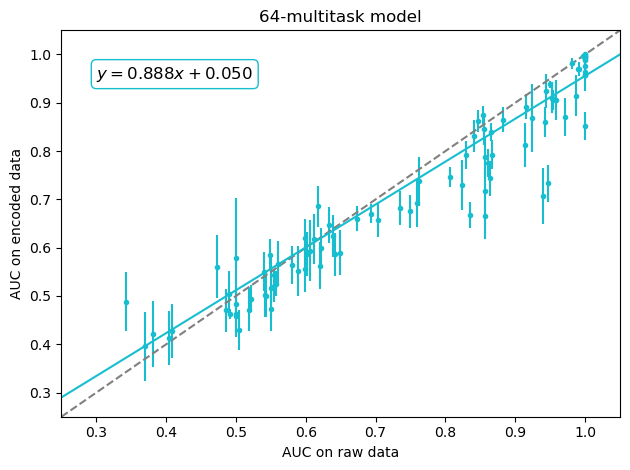

In [9]:
"""
Plot each model's test data as is, so they overlap
"""

for size, color in zip(SIZES, COLORS):
    x_all = default_results[METRIC].to_numpy()
    y_all = list()
    for td in test_dataframes[size]:
        encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
        assert (encoded_td["name"] == default_results["name"]).all()
        assert (encoded_td["target"] == default_results["target"]).all()
        y = encoded_td[METRIC].to_numpy()
        y_all.append(y)

        #plt.scatter(x, y, marker=".", color=color, alpha=0.1)
    
    plt.clf()

    x_all = np.array(x_all)
    y_all = np.array(y_all)
    plt.errorbar(x_all, y_all.mean(axis=0), y_all.std(axis=0), fmt=".", color=color)

    # diagonal line
    ax = plt.gca()
    ax.plot([0, 1], [0, 1], ls="--", c=".5", transform=ax.transAxes)

    line = stats.linregress(x_all, y_all.mean(axis=0))
    ax.plot([0, 1], [line.intercept, line.intercept+line.slope], ls="-", c=color, transform=ax.transAxes)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)

    print(f"Size: {size}, k={line.slope:.3f} $\pm$ {line.stderr:.3f}, n={line.intercept:.3f} $\pm$ {line.intercept_stderr:.3f}")

    #plt.legend()
    plt.xlim(0.25, 1.05)
    plt.ylim(0.25, 1.05)
    plt.xlabel("AUC on raw data")
    plt.ylabel("AUC on encoded data")
    plt.title(f"{size}-{ARCHITECTURE}")
    plt.text(
        0.3, 0.95,
        f"$ y = {line.slope:.3f} x + {line.intercept:.3f} $",
        fontsize=12,
        bbox={"boxstyle": "round", "edgecolor": color, "facecolor": "white"}
    )
    plt.tight_layout()
    if SAVEFIG:
        plt.savefig(f"../figures/results/test/{ARCHITECTURE}_errorbar_{size}.png")
        # plt.savefig(f"../figures/results/test/{ARCHITECTURE}_errorbar_{size}.pdf")

In [ ]:
"""
6 plot - AUC-AUC

TAG: NEWFIGS
"""

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 11), dpi=200)

for ax, size, architecture, name in zip(
    [ax1, ax3, ax5, ax2, ax4, ax6],
    [4, 8, 32, 6, 12, 64],
    ["AutoEncoder", "AutoEncoder", "AutoEncoder", "MultiTask", "MultiTask", "MultiTask"],
    ["autoencoder", "autoencoder", "autoencoder", "multitask model", "multitask model", "multitask model"]
):
    x_all = default_results["roc_auc"].to_numpy()
    y_all = list()
    for i in range(10):
        td = pd.read_csv(f"../models/{architecture}/{size}/{i}/test.csv")
        encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
        assert (encoded_td["name"] == default_results["name"]).all()
        assert (encoded_td["target"] == default_results["target"]).all()
        y = encoded_td["roc_auc"].to_numpy()
        y_all.append(y)

    color = COLORS[SIZES.index(size)]

    x_all = np.array(x_all)
    y_all = np.array(y_all)
    ax.errorbar(x_all, y_all.mean(axis=0), y_all.std(axis=0), fmt=".", color=color, alpha=0.5)
    ax.plot(x_all, y_all.mean(axis=0), ".", color=color)
    # diagonal line
    ax.plot([0, 1], [0, 1], ls="--", c=".5", transform=ax.transAxes)

    line = stats.linregress(x_all, y_all.mean(axis=0))
    ax.plot([0, 1], [line.intercept, line.intercept+line.slope], ls="-", c=color, transform=ax.transAxes)

    print(f"Size: {size}, k={line.slope:.3f} $\pm$ {line.stderr:.3f}, n={line.intercept:.3f} $\pm$ {line.intercept_stderr:.3f}")

    ax.text(
        0.3, 0.95,
        f"$ y = {line.slope:.3f} x + {line.intercept:.3f} $",
        fontsize=12,
        bbox={"boxstyle": "round", "edgecolor": color, "facecolor": "white"}
    )

    ax.set_title(f"{size}-{name}")
    ax.set_xlim(0.25, 1.05)
    ax.set_ylim(0.25, 1.05)
    ax.set_xlabel("AUC on raw data")
    ax.set_ylabel("AUC on encoded data")


fig.tight_layout()
#plt.subplots_adjust(wspace=0.25, hspace=0.4)

# plt.savefig(f"../figures/results/test/AUC_AUC_errorbar.png")

In [ ]:
N = 1_000_000
l = r = 0

print("slope")
l = np.random.normal(0.888, 0.027, N)
r = np.random.normal(0.873, 0.033, N)
print((l > r).sum() / N)

print("intercept")
l = np.random.normal(0.050, 0.021, N)
r = np.random.normal(0.059, 0.025, N)
print((l < r).sum() / N)

l = np.random.normal(0.059, 0.027, N)
r = np.random.normal(0.059, 0.025, N)
print((l < r).sum() / N)

In [ ]:
# Idnetify datasets with interesting results:
# 1: good baseline, worse encoded
# 2: bad baseline, better encoded

x_all = default_results[METRIC].to_numpy()
names_list = np.array([f"{row['name']}-{row['target']}" for _, row in default_results.iterrows()])

# 1. - autoencoder
size = 4
y_all = list()
for td in test_dataframes[size]:
    encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
    assert (encoded_td["name"] == default_results["name"]).all()
    assert (encoded_td["target"] == default_results["target"]).all()
    y = encoded_td[METRIC].to_numpy()
    y_all.append(y)
y_all = np.array(y_all)
y_mean = y_all.mean(axis=0)
print("1.", names_list[(y_mean < 0.5) * (x_all > 0.9)])

# 2. - autoencoder
size = 64
y_all = list()
for td in test_dataframes[size]:
    encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
    assert (encoded_td["name"] == default_results["name"]).all()
    assert (encoded_td["target"] == default_results["target"]).all()
    y = encoded_td[METRIC].to_numpy()
    y_all.append(y)
y_all = np.array(y_all)
y_mean = y_all.mean(axis=0)
print("2.", names_list[(x_all < 0.35)])

In [ ]:
np.where((x_all < 0.35))

In [ ]:
names_list[70:75]

#### Confusion matrix

In [ ]:
"""
Confusion matrix table
"""

for size in SIZES:
    cmat = np.zeros((len(test_dataframes[size]), test_dataframes[size][0].shape[0]//2, 4)) # we remove 'combined'
    for i, td in enumerate(test_dataframes[size]):
        encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
        cmat[i, :, :] = encoded_td[["true_positive", "true_negative", "false_positive", "false_negative"]].to_numpy()
    names = encoded_td["name"] # the last 'encoded_td' is ok
    cmat_mean = cmat.mean(axis=0)
    cmat_std = cmat.std(axis=0)
    with open(f"../figures/results/test/{ARCHITECTURE}_confusion_matrix_{size}.md", "w") as f:
        f.write(f"# Confusion matrix - {ARCHITECTURE.upper()}\n| Dataset name | TP | TN | FP | FN |\n| --- | --- | --- | --- | --- |\n")
        for n, m, s in zip(names, cmat_mean, cmat_std):
            f.write(f"| {n} | ")
            f.write(" | ".join(f"{_m:.1f} $ \pm $ {_s:.1f}" for _m, _s in zip(m, s)))
            f.write("|\n")
    with open(f"../figures/results/test/{ARCHITECTURE}_confusion_matrix_{size}.txt", "w") as f:
        f.write(f"Dataset name & TP & TN & FP & FN \\\\\n")
        for n, m, s in zip(names, cmat_mean, cmat_std):
            f.write(f"{n} & ")
            f.write(" & ".join(f"{_m:.1f} $ \pm $ {_s:.1f}" for _m, _s in zip(m, s)))
            f.write(" \\\\\n")

In [ ]:

"""
Plot true-positive-rate vs true-negative-rate
"""

# baseline results
tmp = default_results[["true_positive", "true_negative", "false_positive", "false_negative"]].to_numpy().sum(axis=0)
x = tmp[0] / (tmp[0] + tmp[3])
y = tmp[1] / (tmp[1] + tmp[2])
plt.scatter(x, y, s=5, c="k")
plt.plot([x, x], [y, y], color="k", alpha=1, label="Baseline")

for size, color in zip(SIZES, COLORS):
    cmat = np.zeros((len(test_dataframes[size]), 4)) # we remove 'combined'
    for i, td in enumerate(test_dataframes[size]):
        encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
        tmp = encoded_td[["true_positive", "true_negative", "false_positive", "false_negative"]].to_numpy()
        cmat[i, :] = tmp.sum(axis=0)

    cmat_mean = cmat.mean(axis=0)
    cmat_std = cmat.std(axis=0)
    positive = cmat[0, 0] + cmat[0, 3]
    negative = cmat[0, 1] + cmat[0, 2]
    
    x_mean = cmat_mean[0] / positive
    x_std = cmat_std[0] / positive
    y_mean = cmat_mean[1] / negative
    y_std = cmat_std[1] / negative

    print(f"Size: {size}, tpr={x_mean:.3f} $\pm$ {x_std:.3f} & tnr={y_mean:.3f} $\pm$ {y_std:.3f}")

    plt.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt=".", color=color)
    plt.plot([x_mean, x_mean], [y_mean, y_mean], color=color, alpha=1, label=size)

plt.legend(loc="upper left")
plt.xlim(0.615, 0.665)
plt.ylim(0.66, 0.92)
plt.xlabel("True positive rate")
plt.ylabel("True negative rate")
if SAVEFIG:
    plt.savefig(f"../figures/results/test/{ARCHITECTURE}_confusion_matrix.png")
    # plt.savefig(f"../figures/results/test/{ARCHITECTURE}_confusion_matrix.pdf")

In [ ]:
N = 1_000_000
l = r = 0

l = np.random.normal(0.653, 0.007, N)  # 16-autoencoder
r = np.random.normal(0.655, 0.004, N)  # 32-multitask
print((l < r).sum() / N)

In [ ]:
"""
Plot true-positive-rate vs true-negative-rate

TAG: NEWFIGS
"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

tmp = default_results[["true_positive", "true_negative", "false_positive", "false_negative"]].to_numpy().sum(axis=0)
x = tmp[0] / (tmp[0] + tmp[3])
y = tmp[1] / (tmp[1] + tmp[2])
ax1.scatter(x, y, s=5, c="k")
ax2.scatter(x, y, s=5, c="k")
ax2.plot([0, 0], [0, 0], color="k", alpha=1, label="Baseline")

for ax, architecture in zip(
    [ax1, ax2],
    ["AutoEncoder", "MultiTask"]
):
    for size, color in zip(SIZES, COLORS):
        test_dataframes = list()
        for i in range(10):
            test_dataframes.append(pd.read_csv(f"../models/{architecture}/{size}/{i}/test.csv"))

        cmat = np.zeros((len(test_dataframes), 4)) # we remove 'combined'
        for i, td in enumerate(test_dataframes):
            encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
            tmp = encoded_td[["true_positive", "true_negative", "false_positive", "false_negative"]].to_numpy()
            cmat[i, :] = tmp.sum(axis=0)

        cmat_mean = cmat.mean(axis=0)
        cmat_std = cmat.std(axis=0)
        positive = cmat[0, 0] + cmat[0, 3]
        negative = cmat[0, 1] + cmat[0, 2]
        
        x_mean = cmat_mean[0] / positive
        x_std = cmat_std[0] / positive
        y_mean = cmat_mean[1] / negative
        y_std = cmat_std[1] / negative

        ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt=".", color=color)
        ax.plot([x_mean, x_mean], [y_mean, y_mean], color=color, alpha=1)

        print(f"{size} & {x_mean:.3f} $ \pm $ {x_std:.3f} & {y_mean:.3f} $ \pm $ {y_std:.3f} \\\\")

for size, color in zip(SIZES, COLORS):
    ax2.plot([0, 0], [0, 0], c=color, label=size)
ax2.legend(title="Size", loc="center left", bbox_to_anchor=(1.02, 0.5), framealpha=0.5, edgecolor="black")

ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)

ax1.set_xlim(0.615, 0.665)
ax2.set_xlim(0.615, 0.665)
ax1.set_ylim(0.66, 0.92)
ax2.set_ylim(0.66, 0.92)
ax1.set_xlabel("True positive rate")
ax2.set_xlabel("True positive rate")
ax1.set_ylabel("True negative rate")
ax2.set_ylabel("True negative rate")
ax1.set_title("Autoencoders")
ax2.set_title("Multi-task models")

fig.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.4)

plt.savefig(f"../figures/results/test/TPR_TNR_errorbar.png")

In [ ]:
"""
Parallel Coordinates Plot
"""

for size, color in zip(SIZES, COLORS):
    cmat = np.zeros((len(test_dataframes[size]), 4)) # we remove 'combined'
    for i, td in enumerate(test_dataframes[size]):
        encoded_td = td[td["input"] == "encoded"].reset_index(drop=True)
        tmp = encoded_td[["true_positive", "true_negative", "false_positive", "false_negative"]].to_numpy()
        cmat[i, :] = tmp.sum(axis=0)

    positive = cmat[0, 0] + cmat[0, 3]
    negative = cmat[0, 1] + cmat[0, 2]

    cmat /= [positive, negative, negative, positive]

    plt.plot([0, 1, 2, 3], cmat.mean(axis=0))
    plt.errorbar([0, 1, 2, 3], cmat.mean(axis=0), cmat.std(axis=0), fmt=".", color=color)
    plt.plot([0, 0], [0, 0], color=color, alpha=1, label=size)
plt.legend(loc="lower left")
plt.xticks([0, 1, 2, 3], ["TP", "TN", "FP", "FN"])

### Plotting encodings

In [ ]:
with open("../figures/results/encodings/explained_variance_ratio.pickle", "rb") as f:
    pca_variance = pickle.load(f)

In [ ]:
SIZES = [4, 5, 6, 7, 8, 10, 12, 16, 32, 64]
COLORS = list(mcolors.TABLEAU_COLORS.keys())

In [ ]:
print(np.where(pca_variance["raw"] >= 0.01)[0][-1]+1)
print(np.where(pca_variance["raw"] >= 0.001)[0][-1]+1)
print(np.where(pca_variance["raw"] >= 0.0001)[0][-1]+1)
print(np.where(pca_variance["raw"] >= 0.00001)[0][-1]+1)
print(pca_variance["raw"].shape)

In [ ]:
# cumsum table
raw_cumsum = pca_variance["raw"].cumsum()
p50 = np.where(raw_cumsum > 0.50)[0][0]+1
p90 = np.where(raw_cumsum > 0.90)[0][0]+1
p95 = np.where(raw_cumsum > 0.95)[0][0]+1
for size in SIZES:
    print(size, end="")
    for model_name in ["AutoEncoder", "MultiTask"]:
        model_cumsum = pca_variance[model_name][size].cumsum(axis=1)
        for limit in [0.5, 0.9, 0.95]:
            idx_lst = np.zeros(10)
            for i, row in enumerate(model_cumsum):
                idx_lst[i] = np.where(row > limit)[0][0]+1
            print(f" & {idx_lst.mean():.1f} $ \pm $ {idx_lst.std():.1f}", end="")
    print(r" \\")
print(f" & {p50} & {p90} & {p95} & {p50} & {p90} & {p95} \\\\")

In [ ]:
# component table
for size in SIZES:
    print(size, end="")
    for model_name in ["AutoEncoder", "MultiTask"]:
        model_variance = pca_variance[model_name][size]
        for i in range(2):
            print(f" & {model_variance.mean(axis=0)[i]:.3f} $ \pm $ {model_variance.std(axis=0)[i]:.3f}", end="")
    print(r" \\")
print(f"raw & {pca_variance['raw'][0]:.3f} & {pca_variance['raw'][1]:.3f} & {pca_variance['raw'][0]:.3f} & {pca_variance['raw'][1]:.3f} \\\\")

In [ ]:
model_variance.mean(axis=0)[0]

In [ ]:
# variance cutoff
for model_name in ["AutoEncoder", "MultiTask"]:
    for size in SIZES:
        model_variance = pca_variance[model_name][size]
        idx_lst = -np.ones((4, 10))
        print(model_name, size)
        print(model_variance.mean(axis=0))
        print(model_variance.std(axis=0))
        for j, limit in enumerate([0.01, 0.001, 0.0001, 0.00001]):
            for i, row in enumerate(model_variance):
                try:
                    idx_lst[j, i] = np.where(row >= limit)[0][-1]+1
                except:
                    break
            j_limit = idx_lst[j, :]
            j_limit = j_limit[j_limit > -1]
            print(f"{j_limit.mean():.1f} \pm {j_limit.std():.1f} ", end="")
        print()

In [ ]:
"""
Read dataset

TAG: NEWFIGS
"""

dataset = Dataset(
    info_path="../data/GEO_v2/training_data_v3.csv",
    column_path="../data/GEO_v2/training_columns.txt",
    path_prefix="../"
)

X = dataset.test._X
colors = dataset.test.dataset_idx

pca = PCA()

In [ ]:
"""
Plot raw pca encodings

TAG: NEWFIGS
"""

x_pca = pca.fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5), dpi=200)
ax.scatter(x_pca[:, 0], x_pca[:, 1], s=1, c=colors)

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")

fig.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.4)

plt.savefig(f"../figures/results/encodings/dataset_pca_l1000.png")

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 7), dpi=200)
ax.scatter(x_pca[:, 0], x_pca[:, 1], s=1, c=colors)

for ax, architecture, name, size, fold in zip(
    [ax1, ax2, ax3, ax4],
    ["AutoEncoder", "AutoEncoder", "MultiTask", "MultiTask"],
    ["autoencoder", "autoencoder", "multitask model", "multitask model"],
    [7, 64, 10, 32],
    [7, 2, 7, 6],
):
    if architecture == "AutoEncoder":
        model = AutoEncoder(encoder_layers=[512, 512], latent_dim=size)
    elif architecture == "MultiTask":
        model = MultiTask(encoder_layers=[512, 512], latent_dim=size, num_tasks=dataset.n_tasks)
    with open(f"../models/{architecture}/{size}/{fold}/model.pickle", "rb") as f:
        checkpoint = pickle.load(f)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    encoded = model.encoder(X).detach().numpy()
    encoded_pca = pca.fit_transform(encoded)
    ax.scatter(encoded_pca[:, 0], encoded_pca[:, 1], s=1, c=colors)

    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(f"{size}-{name}")

fig.tight_layout()
#plt.subplots_adjust(wspace=0.25, hspace=0.4)

plt.savefig(f"../figures/results/encodings/dataset_pca_sample.png")